In [326]:
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor, Normalize, Compose
from torch import device, cuda, manual_seed, nn
from torch.optim import Adam
import torch

import matplotlib.pyplot as plt

In [327]:
DEVICE = device('cuda' if cuda.is_available() else 'cpu')

# Get the data

In [328]:
# Set parameters
batch_size_train = 200
batch_size_test = 1000
lr = 1e-5
epochs = 5

seed = 1
manual_seed(seed);

In [329]:
DATAPATH = 'C:/Users/matan/Documents/data'
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
train_data = MNIST(DATAPATH, train = True, download=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)

test_data = MNIST(DATAPATH, train=False, download=False, transform=transform)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

In [330]:
# Look at examples
examples = enumerate(test_loader)
batch_idx, (images, labels) = next(examples)
print(images.shape)

torch.Size([1000, 1, 28, 28])


# Make and train the model

In [331]:
dim_input = 28*28
dim_hidden = 400
dim_latent = 200
N_train = len(train_data)
print(N_train)

60000


In [332]:
class Encoder(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_latent):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(dim_input, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, dim_hidden)
        self.mu = nn.Linear(dim_hidden, dim_latent)
        self.var = nn.Linear(dim_hidden, dim_latent)

        self.activation = nn.LeakyReLU(0.2) #nn.Tanh()
    
    def forward(self, x):
        h1 = self.activation(self.fc1(x))
        h1 = self.activation(self.fc2(h1))
        return self.mu(h1), self.var(h1)


class Decoder(nn.Module):
    def __init__(self, dim_latent, dim_hidden, dim_input):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(dim_latent, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, dim_hidden)
        self.fc3 = nn.Linear(dim_hidden, dim_input)
        self.activation = nn.LeakyReLU(0.2) #nn.Tanh()

    def forward(self, z):
        h1 = self.activation(self.fc1(z))
        h1 = self.activation(self.fc2(h1))
        #return self.mu(h1), self.var(h1)
        #return torch.tanh(self.fc3(h1))
        return torch.sigmoid(self.fc3(h1))


class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparametrization(self, mean, var):
        eps = torch.randn_like(var).to(DEVICE) # Ransom tensor in same shape as var
        z = mean + var*eps
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        std = torch.exp(0.5 * log_var)
        z = self.reparametrization(mean, std)
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var


def loss_function(x, out, mean, log_var, alpha = 0.01):
    """
    Loss function for the model
    """
    x_hat=out
    #reproduction_loss = nn.functional.mse_loss(x_hat, x)
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KL_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    print("Loss:", (1-alpha)*reproduction_loss, KL_divergence*alpha)
    #return (1-alpha)*100*reproduction_loss + KL_divergence*alpha*100
    #print("Loss:", reproduction_loss, KL_divergence)
    return reproduction_loss*(1-alpha) + KL_divergence*alpha

In [333]:
encoder = Encoder(dim_input, dim_hidden, dim_latent).to(DEVICE)
decoder = Decoder(dim_latent, dim_hidden, dim_input).to(DEVICE)
model = Model(encoder, decoder).to(DEVICE)
optimizer = Adam(model.parameters(), lr=lr)
print(DEVICE)

cuda


In [334]:
# Start training
model.train()

loss_per_epoch = []
for epoch in range(epochs):
    loss_this_epoch = 0
    for batch, (x, _) in enumerate(train_loader):
        batch_size = x.shape[0]
        x = x.view(batch_size, dim_input)   # Flatten
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, logvar = model(x)
        loss = loss_function(x, x_hat, mean, logvar, alpha=0.8)
        loss_this_epoch += loss.item()

        loss.backward()
        optimizer.step()
        #break

    loss_per_epoch.append(loss_this_epoch / ((batch+1)*batch_size))
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", loss_this_epoch / ((batch+1)*batch_size))

Loss: tensor(21753.9844, device='cuda:0', grad_fn=<MulBackward0>) tensor(275.0574, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(21656.3535, device='cuda:0', grad_fn=<MulBackward0>) tensor(212.5549, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(21570.8340, device='cuda:0', grad_fn=<MulBackward0>) tensor(175.5103, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(21471.6309, device='cuda:0', grad_fn=<MulBackward0>) tensor(144.9216, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(21380.1465, device='cuda:0', grad_fn=<MulBackward0>) tensor(129.6880, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(21282.8438, device='cuda:0', grad_fn=<MulBackward0>) tensor(107.6900, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(21182.6934, device='cuda:0', grad_fn=<MulBackward0>) tensor(98.1868, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tensor(21047.8438, device='cuda:0', grad_fn=<MulBackward0>) tensor(89.1052, device='cuda:0', grad_fn=<MulBackward0>)
Loss: tens

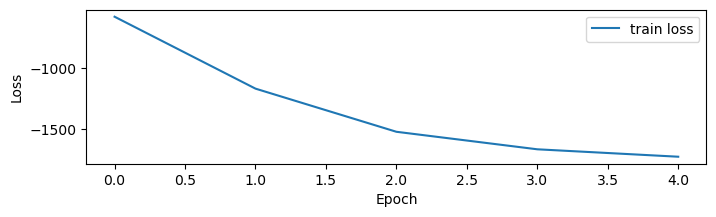

In [ ]:
plt.figure(figsize=(8,2))
plt.plot(range(epochs), loss_per_epoch, label = "train loss")
#plt.plot(range(epochs), validation_loss, label = 'validation_loss')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

# Evaluate the model

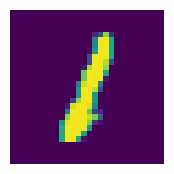

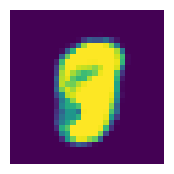

In [ ]:
model.eval()
examples = enumerate(test_loader)
with torch.no_grad():
    batch, (x, labels) = next(examples)
    x = x.view(batch_size_test, dim_input)
    x = x.to(DEVICE)
    x_hat, _, _ = model(x)

def show_image_in_batch(images, idx):
    images = images.view(images.shape[0], 28, 28)
    fig = plt.figure(figsize=(2,2))
    plt.imshow(images[idx].cpu().numpy())
    plt.axis('off')
    plt.show()

show_image_in_batch(x, idx=0)
show_image_in_batch(x_hat, idx=0)
